## Importing modules

In [1]:
import os
import time
import math
import string
import random

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

In [4]:
from utils import evaluate
from utils import training

In [5]:
from importlib import reload

## Loading data

In [6]:
data_dict_re = torch.load("./saves/data/clean_names.pt")

In [7]:
data_in_char = data_dict_re["data_in_char"]
char_vocab = data_dict_re["char_vocab"]

In [8]:
print("data length:", len(data_in_char))
print("vocab size:", len(char_vocab))

data length: 1137
vocab size: 36


In [9]:
print(data_in_char[:5])

[['h', 'a', 'n', 'n', 'a', 'h', ' ', 'a', 'b', 'b', 'o', 't', 't', '<EOS>'], ['a', 'b', 'e', 'l', ' ', 't', 'r', 'e', 'e', 't', 'o', 'p', 's', '<EOS>'], ['e', 'u', 'a', 'n', ' ', 'a', 'b', 'e', 'r', 'c', 'r', 'o', 'm', 'b', 'i', 'e', '<EOS>'], ['a', 'b', 'e', 'r', 'f', 'o', 'r', 't', 'h', ' ', 'd', 'u', 'm', 'b', 'l', 'e', 'd', 'o', 'r', 'e', '<EOS>'], ['a', 'b', 'e', 'r', 'n', 'a', 't', 'h', 'y', '<EOS>']]


In [10]:
char_to_ix = {ch:i for i,ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch,i in char_to_ix.items()}

In [11]:
ix_to_char

{0: '<EOS>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z',
 28: 'á',
 29: 'ã',
 30: 'ä',
 31: 'ç',
 32: 'é',
 33: 'ó',
 34: 'ü',
 35: '<PAD>'}

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, _map, batched):
        self.batched = batched
        
        self.data_as_int = []
        self.max_seqlen = float("-inf")
        self.min_seqlen = float("inf")
        
        # Convert data to integers
        for seq_as_str in data_as_str:
            seq_as_int = evaluate.keys_to_values(seq_as_str, _map,
                random.choice(list(_map)))
            
            self.data_as_int.append(seq_as_int)
            self.max_seqlen = max(self.max_seqlen, len(seq_as_int)-1)
            self.min_seqlen = min(self.min_seqlen, len(seq_as_int)-1)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index, ix
        item = self.data_as_int[ix]
        PAD_ix = char_to_ix["<PAD>"]
        
        # Slice x and y from sample
        x_pad = item[:-1]
        x_len = len(x_pad)
        y_pad = item[ 1:]
        
        # Pad x and y to self.max_seqlen, if self.batched is True
        if self.batched:
            x_pad += ([PAD_ix] * (self.max_seqlen - len(x_pad)))
            y_pad += ([PAD_ix] * (self.max_seqlen - len(y_pad)))
            
        return (torch.tensor(x_pad), torch.tensor(x_len)), torch.tensor(y_pad)

In [13]:
dataset = Dataset(data_in_char, char_to_ix, batched=True)
dataloader = DataLoader(dataset, 16, True)

In [14]:
print("Dataset size:", len(dataset))
print("Max sequence length:", dataset.max_seqlen)
print("Min sequence length:", dataset.min_seqlen)

Dataset size: 1137
Max sequence length: 46
Min sequence length: 2


## Model

In [15]:
class Model(nn.Module):
    def __init__(self, _map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        """
        Input:
            _map: char_to_ix.
            hidden_size: Number of features to learn.
            emb_dim: Size of embedding vector.
            n_layers: Number of layers.
            dropout_p: Dropout probability.
        """
        super(Model, self).__init__()
        
        self.vocab_size  = len(_map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim,
            padding_idx   =_map["<PAD>"])
        
        self.lstm = nn.LSTM(
            input_size =self.emb_dim,
            hidden_size=self.hidden_size,
            num_layers =self.n_layers,
            batch_first=True)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size - 1)
        
    def forward(self, x, prev_state):
        """
        Input:
            x: (x, x_len)
            prev_state: The previous state.
            
        Output:
            out: The output of the model.
            state: The current state.
        """
        n_b, n_s = x[0].shape
        batched = True if (n_b>1 or len(x)>1) else False
        
        embed = self.embedding(x[0])
        
        # Pack-pad embeddings if x is batched
        if batched:
            embed = nn.utils.rnn.pack_padded_sequence(
                embed, x[1], True, False)
            
        yhat, state = self.lstm(embed, prev_state)
        
        # Un-pack-pad the lstm output
        if batched:
            yhat, _ = nn.utils.rnn.pad_packed_sequence(
                yhat, True, total_length=n_s)
            
        yhat = self.dropout(yhat)
        out = self.fc(yhat)
        return out, state
    
    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

In [16]:
model = Model(char_to_ix, 64, 8, n_layers=3, dropout_p=0.2)
model

Model(
  (embedding): Embedding(36, 8, padding_idx=35)
  (lstm): LSTM(8, 64, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=35, bias=True)
)

In [17]:
loss_history = []

## Loading and Saving Model

In [18]:
def load_model(path):
    m_data = torch.load(path)
    
    m = Model(
        _map       =m_data["_map"],
        hidden_size=m_data["hidden_size"],
        emb_dim    =m_data["emb_dim"],
        n_layers   =m_data["n_layers"],
        dropout_p  =m_data["dropout_p"])
    
    m.load_state_dict(m_data["state_dict"])
    l_hist = m_data["loss_history"]
    return m, l_hist

**Uncomment cell to load the trained model**

In [220]:
 model, loss_history = load_model("./saves/model/name_batch.pt")
 

Model(
  (embedding): Embedding(36, 8, padding_idx=35)
  (lstm): LSTM(8, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=35, bias=True)
)

In [19]:
def save_model(m, l_hist, _map, path=None):
    if not path: path = "./saves/model/name_batch.pt"
        
    m_data = {
        "_map"        : _map,
        "hidden_size" : m.hidden_size,
        "emb_dim"     : m.emb_dim,
        "n_layers"    : m.n_layers,
        "dropout_p"   : m.dropout_p,
        "state_dict"  : m.state_dict(),
        "loss_history": l_hist}
    torch.save(m_data, path)

## Training

In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=char_to_ix["<PAD>"])

In [21]:
dataloader

In [22]:
iteration = 10000
per_iter = 1000
start_t = time.time()

for _ti in range(iteration//per_iter):
    model, costs = training.train(
        model, dataloader, per_iter, criterion, clip=0.25, lr=1e-3, print_every=200)
    
    loss_history.extend(costs)
    save_model(model, loss_history, char_to_ix)
    time.sleep(5)
    
    print("\n" + "="*50)
    print("Round: {:2} of {:2}, Running Time: {:7.2f} sec".format(
        _ti+1, iteration//per_iter, time.time() - start_t))
    print("="*50 + "\n")

Iteration:  200/1000, Loss:   3.1011
Iteration:  400/1000, Loss:   2.9700
Iteration:  600/1000, Loss:   2.8735
Iteration:  800/1000, Loss:   2.7375
Iteration: 1000/1000, Loss:   2.6004

Round:  1 of 10, Running Time:   31.10 sec

Iteration:  200/1000, Loss:   2.5319
Iteration:  400/1000, Loss:   2.4847
Iteration:  600/1000, Loss:   2.4405
Iteration:  800/1000, Loss:   2.3994
Iteration: 1000/1000, Loss:   2.3563

Round:  2 of 10, Running Time:   62.46 sec

Iteration:  200/1000, Loss:   2.3242
Iteration:  400/1000, Loss:   2.2711
Iteration:  600/1000, Loss:   2.2331
Iteration:  800/1000, Loss:   2.1945
Iteration: 1000/1000, Loss:   2.1486

Round:  3 of 10, Running Time:   93.88 sec

Iteration:  200/1000, Loss:   2.1150
Iteration:  400/1000, Loss:   2.0773
Iteration:  600/1000, Loss:   2.0355
Iteration:  800/1000, Loss:   1.9967
Iteration: 1000/1000, Loss:   1.9511

Round:  4 of 10, Running Time:  124.37 sec

Iteration:  200/1000, Loss:   1.9133
Iteration:  400/1000, Loss:   1.8749
Iterat

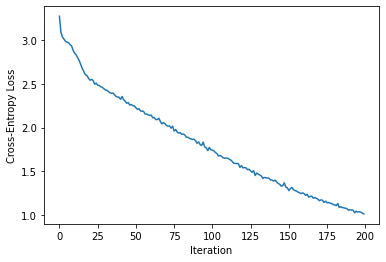

In [23]:
cum = 50
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.plot(
    [sum(loss_history[i:i+cum])/cum for i in range(0, len(loss_history), cum)])

In [24]:
print("Iter: {} | Min: {:.4f} | Max: {:.4f} | Last: {:.4f} | Ave: {:.4f}".format(
    len(loss_history), min(loss_history), max(loss_history), loss_history[-1],
    sum(loss_history)/len(loss_history)))

Iter: 10000 | Min: 0.5205 | Max: 3.9286 | Last: 0.9852 | Ave: 1.8078


## Evaluating

In [25]:
n_samp = 100
ix_list = list(char_to_ix.values())[1:-1]

In [26]:
originality = evaluate.originality(
    n_samp, dataset.data_as_int, evaluate.sample, model, ix_list,
    4, False, dataset.max_seqlen, char_to_ix["<EOS>"])

Duplicates: 4 of 100
  4.00% recall
 96.00% original


Initialise sampling with a **randomly chosen character**

In [27]:
for i in range(30):
    seed = random.choice(ix_list)
    
    print(ix_to_char[seed], "=>", "".join(evaluate.keys_to_values(
        evaluate.sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

á => áirela black<EOS>
c => carros leran<EOS>
v => violetta foul<EOS>
ü => ülmar crimberton<EOS>
ó => óyan lorscewout<EOS>
u => urg the umbian<EOS>
i => irg ambary hillitt<EOS>
k => kevin bergot<EOS>
  =>  heirpa rughert<EOS>
l => larda rumberd<EOS>
j => josef wronski<EOS>
s => semtie werma<EOS>
i => irninste<EOS>
c => calpholthusk fakermone<EOS>
o => olymme rake<EOS>
ü => ündolit black<EOS>
g => gamrick rawless<EOS>
o => ordan the billacord<EOS>
o => oliver ringe<EOS>
ã => ãóóããããããäeenia croke<EOS>
f => fenrax lockal<EOS>
y => yalsun gory<EOS>
x => xerildont<EOS>
é => éthink<EOS>
ó => óvurdor murgle<EOS>
f => flin robott<EOS>
ã => ãäidy tuckle bontwone<EOS>
t => tiny moun<EOS>
m => mary eadeieiua blaccwealel<EOS>
s => stumby breadgle lockirs<EOS>


Initialise sampling with **a list of characters** instead of a single character

In [32]:
for i in range(10):
    word = "julia"
    seed = evaluate.keys_to_values(list(word), char_to_ix, char_to_ix["<PAD>"])
    
    print(word, "=>", "".join(evaluate.keys_to_values(
        evaluate.sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

julia => julia sama rame<EOS>
julia => julia stict<EOS>
julia => julia luccurin<EOS>
julia => julia bashrilbey<EOS>
julia => julia guande<EOS>
julia => julia scrame<EOS>
julia => julia lankith ovy<EOS>
julia => julia black<EOS>
julia => julia stiir woot<EOS>
julia => julia santurriandowoy<EOS>


Sample the next **most likely character** instead of the next **topk most likely characters**

In [29]:
for ch in char_vocab:
    seed = char_to_ix[ch]
    
    print("{:->5}".format(ch), "=>", "".join(evaluate.keys_to_values(
        evaluate.sample(model, seed, 1, True, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

<EOS> => <EOS>hifgory ruk<EOS>
----  =>  lavinal stumbey<EOS>
----a => archie aymslowe<EOS>
----b => barnabas cuffe<EOS>
----c => carlos clodooddo<EOS>
----d => darier black<EOS>
----e => elias story<EOS>
----f => frank bones<EOS>
----g => gridgor<EOS>
----h => hermena barshort<EOS>
----i => irma crabbe<EOS>
----j => josef wranla<EOS>
----k => king hontamey<EOS>
----l => landendina jambort<EOS>
----m => mary morkins<EOS>
----n => nidy caldon<EOS>
----o => oliver ringe<EOS>
----p => professor mordincut<EOS>
----q => quintia qurarelle<EOS>
----r => rodelina flankey<EOS>
----s => stubby balbitt<EOS>
----t => the grey le the hant<EOS>
----u => uncle biliande<EOS>
----v => violetta bob william sornane<EOS>
----w => williamson<EOS>
----x => xarius sterwroc<EOS>
----y => yann flemot<EOS>
----z => zacharias smith<EOS>
----á => áannledo boot<EOS>
----ã => ãóóããããããããããããããããããããããóóóóó
----ä => äargar the longan<EOS>
----ç => çilly poddere<EOS>
----é => éudnertt<EOS>
----ó => óyan lorcicie patt